In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import graph_nets as gn
import sonnet as snt

from copy import deepcopy

# there are some grievances with python 3.8 and tensorflow when it comes to the graph_nets.utils_tf module.
# you *might* have to go and manually change the .as_list() calls calls for every single call to a simpler list() 
# inside two python files... even if you follow the exact installation instructions :|

%matplotlib inline

# Motivation

    1. Find proper graph data for the purposes of NEW NODE prediction
    2. Split said graph data in a meaningful way in terms of training + testing + validation
    2.1 Can we do leave-one-out training with graphs or even just single EDGES?


The NEW NODE prediction is really turned into an EDGE prediction problem.
We cannot try to predict every single imaginable EDGE in the graph -- the new edges we try to predict must be chosen somehow.

The questions are: what are the chosen edges in the training data, and how do we figure out those "interesting" edges in the testing data?
    
Do we actually need to split this into 2 problems:
    
    1. What edges do we need to predict?
    2. What edges actually exist?



# Approach

    1. We will build a VERY simple dataset by hand with only some small amount of graphs that are ~similar.
    2. The data will be split into training, testing and validation data.
    3. We will then proceed to build a simple model that solves this problem by OVERFITTING into the training data to make sure that the approach is viable.
    4. When the first model has been fit, the final step will be to make sure the results are actually what we aimed for. 
    

In [2]:
M, N = 2, 3

G = nx.generators.lattice.grid_2d_graph(M, map(int, np.linspace(0, N-1, N)))
original_graph = deepcopy(G)

nx.set_node_attributes(G, {k: {'features': [0.0]} for k in G.nodes()})
nx.set_edge_attributes(G, {k: {'features': [0.0]} for k in G.edges()})

G = nx.convert_node_labels_to_integers(G)

GRAPHS_TUPLES = gn.utils_np.networkxs_to_graphs_tuple([G])

GRAPHS_TUPLES = gn.utils_tf.set_zero_global_features(GRAPHS_TUPLES, 1, dtype=np.float64)


In [3]:
# 100% aside... since I wanted to calculate new positions for the labels that were nicely placed on a circle around the center point 
# of my nice little rectangle, I decided to figure out how to translate the example grid into a circle:


# https://stackoverflow.com/questions/13211595/how-can-i-convert-coordinates-on-a-circle-to-coordinates-on-a-square
# https://arxiv.org/ftp/arxiv/papers/1509/1509.06344.pdf

# this is a surprisingly interesting problem

#xCircle = xSquare * sqrt(1 - 0.5*ySquare^2)
#yCircle = ySquare * sqrt(1 - 0.5*xSquare^2)

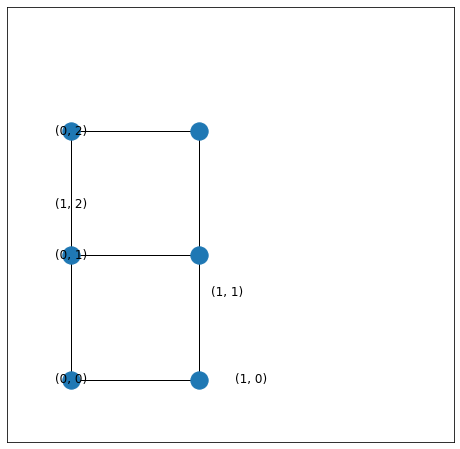

In [4]:

pos = {index: coord for index,(coord,_) in zip(G.nodes(), original_graph.nodes(data=True)) }    

label_pos=[(x*np.sqrt(2-0.5*y**2), y*np.sqrt(1-0.5*x**2)) for x,y in pos.values()]

plt.figure(figsize=(8,8))
plt.xlim(-0.5,3)
plt.ylim(-0.5, 3)
nx.draw_networkx_labels(G, pos=label_pos, labels=pos)
nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos)

In [5]:

# map the global features, node features and edge features just 1-to-1 for now to make sure the network accepts the inputs 

graph_net_module = gn.modules.GraphNetwork(
    edge_model_fn=lambda: snt.nets.MLP([1, 1]),
    node_model_fn=lambda: snt.nets.MLP([1, 1]),
    global_model_fn=lambda: snt.nets.MLP([1, 1]))


first_run = graph_net_module(GRAPHS_TUPLES)

Let's use only 1 graph in our batch and the nodes don't have any features -- they only have 

* First we do Link Prediction for G


In [6]:
first_run

GraphsTuple(nodes=<tf.Tensor: shape=(6, 1), dtype=float64, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])>, edges=<tf.Tensor: shape=(7, 1), dtype=float64, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])>, receivers=array([3, 1, 4, 2, 5, 4, 5]), senders=array([0, 0, 1, 1, 2, 3, 4]), globals=<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.]])>, n_node=array([6]), n_edge=array([7]))

# LINEGRAPH -- to be worried about later...

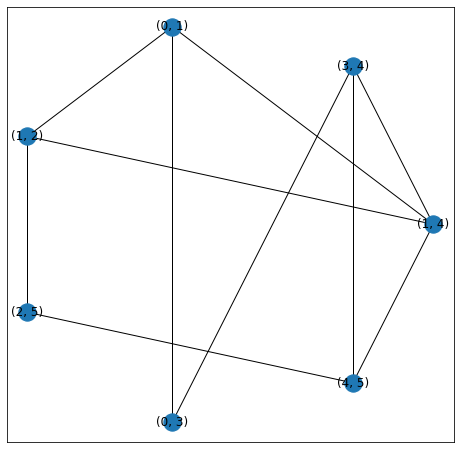

In [7]:
G_linegraph = nx.generators.line_graph(G)

plt.figure(figsize=(8,8))

pos_linegraph = nx.drawing.layout.circular_layout(G_linegraph)
nx.draw_networkx_labels(G_linegraph, pos=pos_linegraph)
nx.draw_networkx_nodes(G_linegraph, pos=pos_linegraph)
nx.draw_networkx_edges(G_linegraph, pos=pos_linegraph)